In [1]:
import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# ssl_features_train = np.load("./old_but_full_features/self_supervised_cifar100/features_train2.npy")
# ssl_labels_train = np.load("./old_but_full_features/self_supervised_cifar100/labels_train2.npy")
# ssl_features_test = np.load("./old_but_full_features/self_supervised_cifar100/features_test2.npy")
# ssl_features_ood = np.load("./old_but_full_features/self_supervised_cifar100/features_ood2.npy")


# sp_features_train = np.load("./old_but_full_features/supervised_cifar100/features_train2.npy")
# sp_labels_train = np.load("./old_but_full_features/supervised_cifar100/labels_train2.npy")
# sp_features_test = np.load("./old_but_full_features/supervised_cifar100/features_test2.npy")
# sp_features_ood = np.load("./old_but_full_features/supervised_cifar100/features_ood2.npy")



ssl_features_train = np.load("./self_supervised_cifar100/features_train.npy")
ssl_labels_train = np.load("./self_supervised_cifar100/labels_train.npy")
ssl_features_test = np.load("./self_supervised_cifar100/features_test.npy")
ssl_features_ood = np.load("./self_supervised_cifar100/features_ood.npy")


sp_features_train = np.load("./supervised_cifar100/features_train.npy")
sp_labels_train = np.load("./supervised_cifar100/labels_train.npy")
sp_features_test = np.load("./supervised_cifar100/features_test.npy")
sp_features_ood = np.load("./supervised_cifar100/features_ood.npy")

In [2]:
# -- calculate SL and SSL score separately


import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def get_roc_sklearn(xin, xood):
    labels = [0] * len(xin) + [1] * len(xood)
    data = np.concatenate((xin, xood))
    auroc = skm.roc_auc_score(labels, data)
    return auroc


def get_scores_multi_cluster(ftrain, ftest, food, ypred):
    print("using multiple clusters")
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    

    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
#     print("din shape is looking like:", din)
    din_index = np.argmin(din, axis = 0)
    
    din = np.min(din, axis=0)
    
    dood_index = np.argmin(dood, axis = 0)
    dood = np.min(dood, axis=0)

    return din, dood, din_index, dood_index

def get_scores(ftrain, ftest, food, labelstrain, cluster):

    # standardize data
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
    
    return get_scores_multi_cluster(ftrain, ftest, food, labelstrain)   # for supervised learning

def get_eval_results(dtest, dood):
    """
    None.
    """

    auroc = get_roc_sklearn(dtest, dood)
    return auroc

In [3]:
#calculate score of id test samples and ood test samples

# Get features --> individual cluster (self-sp and sp) --> calcualte score

ssl_din, ssl_dout, ssl_idxin, ssl_idxood = get_scores(ssl_features_train, ssl_features_test, ssl_features_ood, ssl_labels_train, cluster = 10)

sp_din, sp_dout, sp_idxin, sp_idxood = get_scores(sp_features_train, sp_features_test, sp_features_ood, sp_labels_train, cluster = 10)


ftrain size is: (5000, 2048)
using multiple clusters
ftrain size is: (5000, 2048)
using multiple clusters


In [29]:
auroc = get_eval_results(ssl_din, ssl_dout)

print("AUROC is:", auroc)

auroc = get_eval_results(sp_din, sp_dout)

print("AUROC is:", auroc)


AUROC is: 0.85158188
AUROC is: 0.87471592


In [5]:
np.save("./self_supervised_cifar100/ssl_test_score.npy",ssl_din)
np.save("./self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
np.save("./supervised_cifar100/sl_test_score.npy",sp_din)
np.save("./supervised_cifar100/sl_ood_score.npy",sp_dout)
np.save("./supervised_cifar100/sl_ood_minlabels.npy",sp_idxood)
np.save("./supervised_cifar100/sl_test_minlabels.npy",sp_idxin)
np.save("./self_supervised_cifar100/ssl_ood_minlabels.npy",ssl_idxood)
np.save("./self_supervised_cifar100/ssl_test_minlabels.npy",ssl_idxin)



In [6]:
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_test_score.npy",ssl_din)
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
# np.save("./old_but_full_features/supervised_cifar100/sl_test_score.npy",sp_din)
# np.save("./old_but_full_features/supervised_cifar100/sl_ood_score.npy",sp_dout)


In [7]:
# calculate score for combined feature



ssl_features_train = np.load("./self_supervised_cifar100/features_train.npy")
ssl_labels_train = np.load("./self_supervised_cifar100/labels_train.npy")
ssl_features_test = np.load("./self_supervised_cifar100/features_test.npy")
ssl_features_ood = np.load("./self_supervised_cifar100/features_ood.npy")


sp_features_train = np.load("./supervised_cifar100/features_train.npy")
sp_labels_train = np.load("./supervised_cifar100/labels_train.npy")
sp_features_test = np.load("./supervised_cifar100/features_test.npy")
sp_features_ood = np.load("./supervised_cifar100/features_ood.npy")



import matplotlib.pyplot as plt

def dnorm(ftrain, ftest, food):
    
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)
    print("mean value is:", np.mean(m))
    print("std value is:", np.mean(s))
#     m2, s2 = np.mean(ftest, axis=0, keepdims=True), np.std(ftest, axis=0, keepdims=True)
#     m3, s3 = np.mean(food, axis=0, keepdims=True), np.std(food, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
#     print("ftrain shape is:", ftrain.shape)
#     ftrain = (ftrain - m) / (s + 1e-10)
#     ftest = (ftrain - m2) / (s2 + 1e-10)
#     food = (ftrain - m3) / (s3 + 1e-10)

#     plt.figure(0).clf()
#     plt.plot(food[960])
#     plt.hist(ftrain[60], density=True, bins=100)
#     plt.show()
    
    
    return ftrain, ftest, food

ssl_features_train,  ssl_features_test, ssl_features_ood= dnorm(ssl_features_train, ssl_features_test, ssl_features_ood)
sp_features_train,  sp_features_test, sp_features_ood= dnorm(sp_features_train, sp_features_test, sp_features_ood)


fl_features_train = 0.3 * ssl_features_train + 0.7 * sp_features_train
fl_features_test = 0.3 * ssl_features_test + 0.7 * sp_features_test
fl_features_ood = 0.3 * ssl_features_ood + 0.7 * sp_features_ood
print("new fl_feature_train size is:", fl_features_train.shape)

fl_din, fl_dout, fl_idxin, fl_idxood = get_scores_multi_cluster(fl_features_train, fl_features_test, fl_features_ood, ssl_labels_train)

ftrain size is: (5000, 2048)
mean value is: 0.010127474
std value is: 0.01841798
ftrain size is: (5000, 2048)
mean value is: 0.011216093
std value is: 0.01259813
new fl_feature_train size is: (5000, 2048)
using multiple clusters


In [8]:
auroc = get_eval_results(fl_din, fl_dout)

print("AUROC is:", auroc)


AUROC is: 0.8938611599999999


In [9]:
np.save("./ensemble_cifar100/fl_test_score.npy",fl_din)
np.save("./ensemble_cifar100/fl_ood_score.npy",fl_dout)
np.save("./ensemble_cifar100/fl_ood_minlabels.npy",fl_idxood)
np.save("./ensemble_cifar100/fl_test_minlabels.npy",fl_idxin)

In [10]:
print(sp_dout)
print(sp_din)

[2699.14289933 2054.79580636 3017.00457251 ...  971.70151599 4214.53259711
  999.0136564 ]
[ 614.27246558 1375.03965714 1099.3319781  ...  965.77903413  474.87222485
  682.23108487]


In [ ]:
f_change= fl_dout - sp_dout
indices = (-f_change).argsort()[:10]
print(indices)

In [ ]:
plt.figure(0).clf()
plt.plot(sp_features_ood[645])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

idx = 5633
plt.figure(0).clf()
plt.plot(ssl_features_ood[idx])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()
print((-ssl_features_ood[idx]).argsort()[:10])

In [11]:
## calculate fpr, tpr, Threshold 

labels = [0] * len(fl_din) + [1] * len(fl_dout)
print("length of labels is:", len(labels))
data = np.concatenate((fl_din, fl_dout))
fpr, tpr, thresh = roc_curve(labels, data)
thresh.size

length of labels is: 10000


2638

In [21]:
## select threshold that fpr approximates to 0.23
Th = thresh[1950]
print(Th)
index = np.where(sp_din > Th)[0]
print(index.size)
print(index.size/5000)

780.8173216588731
2109
0.4218


In [22]:
ood_labels = np.load("./supervised_cifar100/labels_ood.npy")

In [30]:
## get false negative index and number
index2 = np.where(ssl_dout > Th)[0]
# print(index[:150])
print(index2.size/5000)
# print(ood_labels[:150])

0.7886


In [26]:
index1 = np.where(fl_dout > Th)[0]
# print(index1)
index1.size/5000

0.9112

length of labels is: 10000
size of threshold is : [8493.10216932 8492.10216932 5389.71304273 ...  342.79660644  342.29351848
  260.45548402]
size of fpr is : [0.     0.     0.     ... 0.9964 0.9964 1.    ]
size of tpr is : [0.000e+00 2.000e-04 6.800e-03 ... 9.998e-01 1.000e+00 1.000e+00]


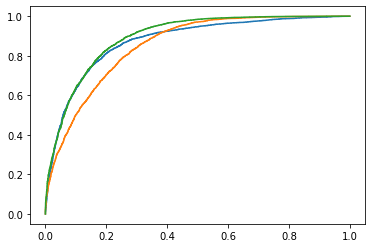

In [27]:
def get_roc_sklearn_plot1(xin1, xood1, xin2, xood2, xin3, xood3):
    
    labels1 = [0] * len(xin1) + [1] * len(xood1)
    print("length of labels is:", len(labels1))
    data1 = np.concatenate((xin1, xood1))
    labels2 = [0] * len(xin2) + [1] * len(xood2)
    data2 = np.concatenate((xin2, xood2))
    labels3 = [0] * len(xin3) + [1] * len(xood3)
    data3 = np.concatenate((xin3, xood3))
    
    plt.figure(0).clf()
    fpr, tpr, thresh = roc_curve(labels1, data1)
    print("size of threshold is :", thresh)
    plt.plot(fpr,tpr,label="SL")
    print("size of fpr is :", fpr)
    print("size of tpr is :", tpr)
    
    fpr, tpr, thresh = roc_curve(labels2, data2)
    plt.plot(fpr,tpr,label="SSL")
    
    
    fpr, tpr, thresh = roc_curve(labels3, data3)
    plt.plot(fpr,tpr,label="Ensemble")
    
get_roc_sklearn_plot1(sp_din, sp_dout, ssl_din, ssl_dout, fl_din, fl_dout)

In [ ]:
fn_to_tp = np.setdiff1d(index, index1)
print(fn_to_tp[:150])
print(ood_labels[fn_to_tp[:150]])
print(ood_labels[50])

In [ ]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.9 * sp_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.1 * ssl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(1).clf()
plt.plot(0.1 * fl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


In [ ]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.9 * sp_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.1 * ssl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(1).clf()
plt.plot(0.1 * fl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

In [ ]:
## find the largest values in ssl feature

ssl_idx = (-ssl_features_ood[6]).argsort()[:10]
ssl_idx

In [ ]:
sp_features_ood[6][986]

In [ ]:
ssl_idx = (-ssl_features_ood[17]).argsort()[:10]
ssl_idx

In [ ]:
a = [1, 2, 3]
b = [1]